# Modelamiento con sitios CpG (GDC + METHBANK)

## Librerías y path

In [1]:
import sys
from pathlib import Path
import os

src_path = str(Path.cwd().parents[0] / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

raw_path = str(Path.cwd().parents[0] / "data" / "raw")
preprocess_path = str(Path.cwd().parents[0] / "data" / "preprocessed")

In [2]:
import seaborn as sns    
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
np.random.seed(42)

## Lectura y preprocesamiento básico

In [3]:
df = pd.read_csv(f"{preprocess_path}/gdc_methbank.csv")
df.head()

,cg02004156,cg04037732,cg04344997,cg04702045,cg04765675,cg05935584,cg06700462,cg06791102,cg06899582,cg08798116,...,cg27158143,cg27187881,cg27281093,cg27324619,cg27378424,cg27416437,cg27532722,cg27553637,cg27611781,sample_type
0,0.312,0.336,0.493,0.372,0.051,0.586,0.385,0.521,0.192,0.462,...,0.104,0.092,0.112,0.278,0.048,0.075,0.428,0.052,0.143,Solid Tissue Normal
1,0.427,0.410,0.484,0.372,0.044,0.538,0.340,0.529,0.252,0.452,...,0.092,0.135,0.081,0.342,0.042,0.069,0.504,0.073,0.137,Solid Tissue Normal
2,0.384,0.446,0.524,0.318,0.045,0.508,0.335,0.467,0.205,0.421,...,0.091,0.072,0.171,0.417,0.048,0.056,0.576,0.057,0.146,Solid Tissue Normal
3,0.381,0.485,0.438,0.210,0.047,0.655,0.383,0.515,0.154,0.399,...,0.121,0.058,0.087,0.243,0.042,0.048,0.599,0.050,0.154,Solid Tissue Normal
4,0.322,0.365,0.352,0.304,0.038,0.456,0.322,0.390,0.188,0.433,...,0.055,0.092,0.095,0.292,0.052,0.080,0.501,0.052,0.088,Solid Tissue Normal


In [4]:
x, y = df.drop(columns =['sample_type']), df['sample_type'].replace({'Primary Tumor':1, 'Solid Tissue Normal':0})
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, stratify=y, random_state=42)

## Selección de características

Para selección de características se utilizan los métodos de PCA (método del codo) y Random Forest 

### PCA

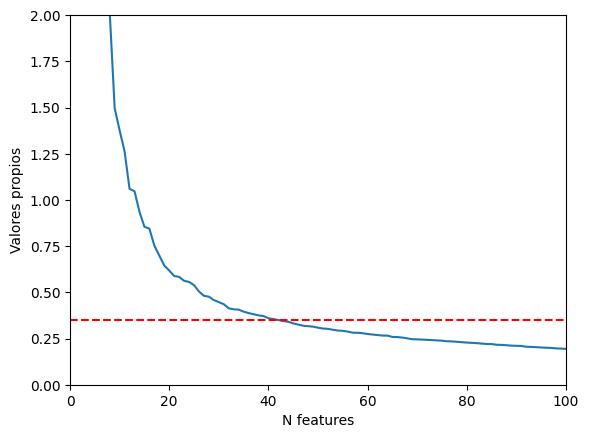

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

covar_matrix = PCA(random_state=42)
covar_matrix.fit(x_train)
plt.plot(covar_matrix.explained_variance_)
plt.ylim(0, 2)
plt.xlim(0, 100)
plt.axhline(y=0.35, color = 'r', linestyle='--')
plt.xlabel("N features")
plt.ylabel('Valores propios')
plt.show()

In [7]:
pca = PCA(n_components = 40)
pca.fit(x_train)
x_pca = pca.transform(x_train)
x_pca.shape

(643, 40)

### Random Forest

In [22]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

selector = SelectFromModel(RandomForestClassifier(random_state=42))
selector.fit(x_train, y_train)
x_forest = selector.transform(x_train)
x_forest.shape

(643, 387)

## Modelamiento

Se utilizan los clasificadores SVM, Random Forest y XGBoost

In [15]:
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from modeling_utils import metrics_heatmap, fit_estimators_from_dict, predict_from_dict
base_estimators = {'SVC': SVC(random_state=42),'XGB': XGBClassifier(random_state=42), 'RF': RandomForestClassifier(random_state=42)}

### Features por PCA

In [13]:
pca_estimators = fit_estimators_from_dict(x_pca, y_train, base_estimators)

In [17]:
pca_pred_test = predict_from_dict(pca.fit_transform(x_test), pca_estimators)

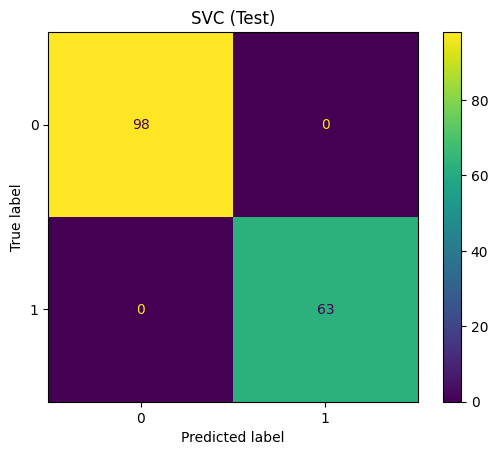

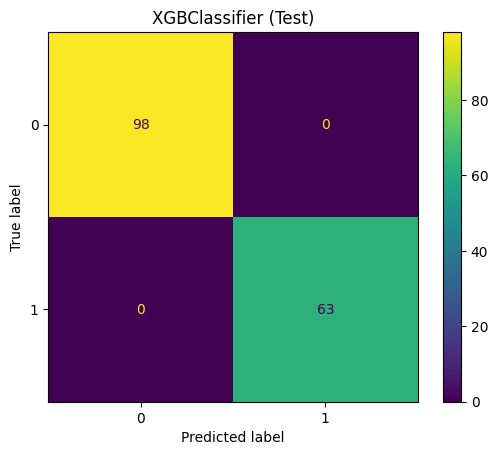

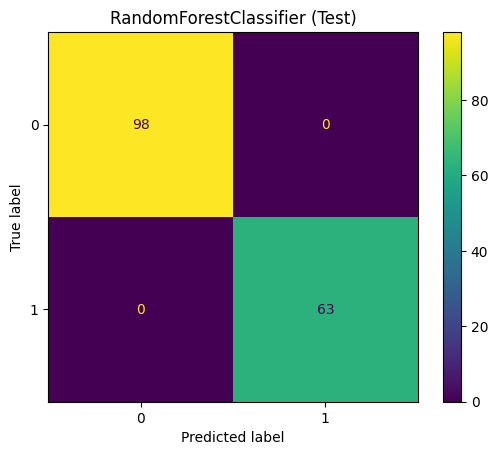

In [18]:
for estim in pca_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, pca_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

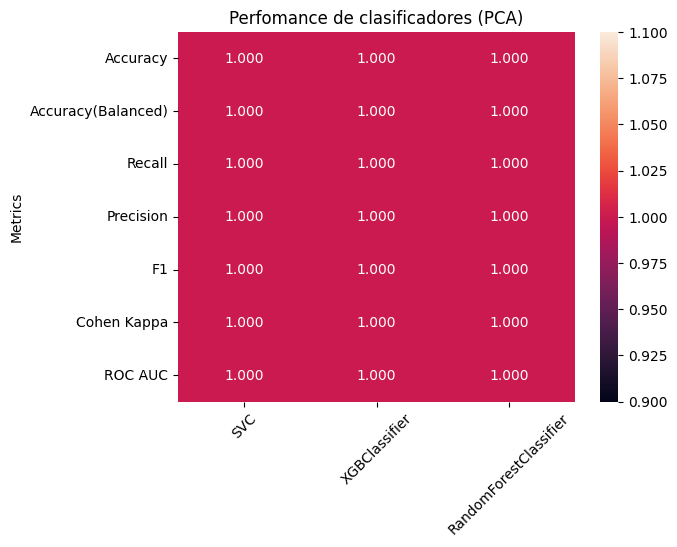

In [19]:
metrics_heatmap(y_test, pca_pred_test, 'Perfomance de clasificadores (PCA)')

### Features por Random Forest

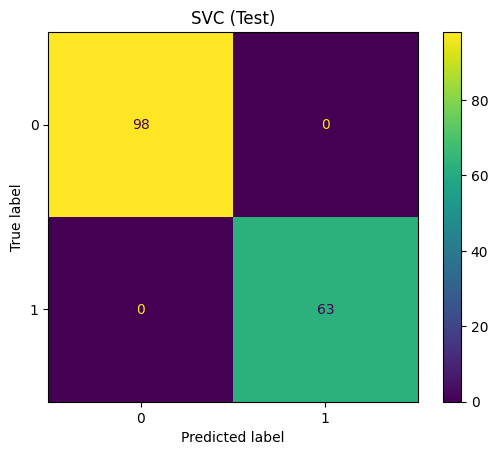

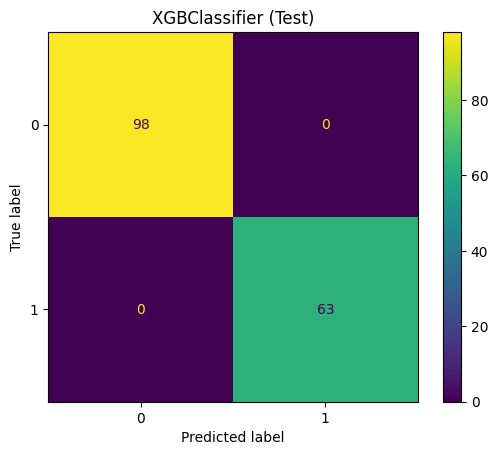

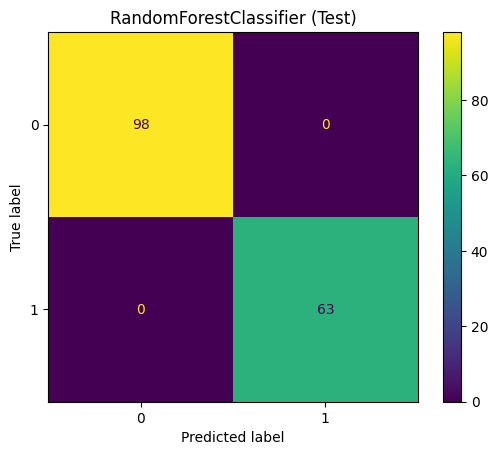

In [24]:
rf_estimators = fit_estimators_from_dict(x_forest, y_train, base_estimators)
rf_pred_test = predict_from_dict(selector.transform(x_test), rf_estimators)
for estim in rf_pred_test:
    ConfusionMatrixDisplay.from_predictions(y_test, rf_pred_test[estim])
    plt.title(f"{estim} (Test)")
    plt.show()

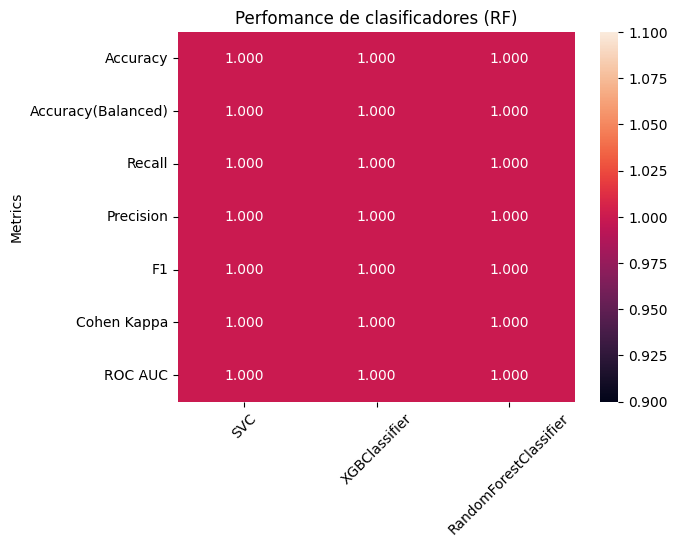

In [25]:
metrics_heatmap(y_test, rf_pred_test, 'Perfomance de clasificadores (RF)')